# Performing approximation optimization target experiments

In this Jupyter notebook we repeat the single approximation optimization target baseline experiments with rescaled x-axis for every basis,  
as experiments performed in 02_segment_size_considerations.ipynb document that every basis has a favourable x-axis range.  
(As expected for e.g. Chebyshev basis, as it only is a basis for polynomials in the range $[-1, 1]$.)

Version 2.0  
Date: 2024-01-15  
Current version: hannes.waclawek@fh-salzburg.ac.at  
Initial Version: stefan.huber@fh-salzburg.ac.at  

In [2]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import multiprocessing as mp
from itertools import repeat

from tfspline import model, parallel, plot, sampledata

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
lambd = 1
no_segments = 1
factor_ck_pressure = 0
factor_approximation_quality = 1
learning_rate = 0.1
shift_polynomial_centers = 'mean' # Power and Chebyshev Basis
shift_polynomial_centers_sc = 'boundary' # Shifted Chebyshev Basis
ck = 2

colors = list(mcolors.TABLEAU_COLORS.keys())

# How is convergence influenced?

## Generally  
Performance of Chebyshev and Shifted Chebyshev Base almost identical  
**--> We can skip Shifted Chebyhsev Base in future experiments, as its x-range tolerance is much lower.**  
  
## Degree  
  
**Generally, with the algorithm presented in our last paper:**  
- **Minimum Degree 5 is required to strictly establish $C^2$-continuity.**  
- **Minimum Degree 7 is required to strictly establish $C^3$-continuity.**  
  
With rising degree, the theoretically possible l2-optimum gets lower.  
This is in accordance with Chebyshev and Shifted Chebyshev performance observed here,  
these bases manage to converge to a lower loss with rising degree.  
This is not the case for Power Basis. While performance with degree 5 is very good,  
higher degrees perform worse.  
As expected, higher degrees generally require more epochs to converge.  
For Chebyshev and Shifted Chebyshev results converge for all observed degrees (3-9) within 1000 epochs.  
Power basis with degree 5 is competitive, but higher degrees clearly perform worse.  
  
## Learning rate and number of epochs  
  
For Power basis, higher learning rates may be beneficial for higher degrees, as these perform much worse than degree 5.  
However, we cannot rise learning rates arbitrarily high, as results will diverge.  
**For Chebyshev and Shifted Chebyshev a learning rate of 1.0 with 1000 epochs seems to be a reasonable choice for all observed degrees.**  
  
## Number of points to be approximated  
  
With all observed bases the effect is mild.  
Raising the number of points has almost no effect to the highest learning rate we can achieve.  
Of course, the number of input points has to be sufficiently high for a degree for a well-conditioned fit in the first place.  
  
## Optimizers  
  
Chebyshev and Shifted chebyshev is performing (almost) identically and clearly outperforming Power Basis in regard to all observed optimizers.
**None of the optimizers manage to reach the l2 optimum with Power basis in the given 5000 epochs.**
**There are, however, several optimizers that achieve this with Chebyshev basis.** Quickest convergence:
1. nadam, adagrad, ftrl
2. Vanilla SGD, SGD with Nesterov momentum, adam, adamax, amsgrad
3. SGD with momentum, adadelta

We don't consider stability after reaching the optimum, as early stopping is an option.
As our main goal is performing combined approximation and continuity optimization in the next Jupyter notebook,
we don't look into optimizing hyerparameters of individual optimizers here.
  
**Interesting: Vanilla SGD is outperforming "modern" adaptive AMSGrad with Chebyshev basis.**  
  
## Variation in dataset  
  
Generally it takes longer to get to the optimal approximation result for all bases with less noise.  
Hovewer, while Chebyshev and Shifted Chebyshev bases are able to reach the l2-optimum for all observed noise levels in under 500 epochs,   
Power Basis is only competitive with noise added to the input curve.  

In [5]:
# Optimal optimizer parameters found in this notebook
def get_optimizer(basis='', optimizer='', learning_rate=0.1):
    if optimizer == 'sgd':
        if basis == 'power':
            opt = keras.optimizers.SGD(momentum=0.95, learning_rate=learning_rate)
        else:
            opt = keras.optimizers.SGD(momentum=0.9, learning_rate=learning_rate)
    else:
        opt = keras.optimizers.Adam(amsgrad=True, learning_rate=learning_rate)     
    return opt

## Data


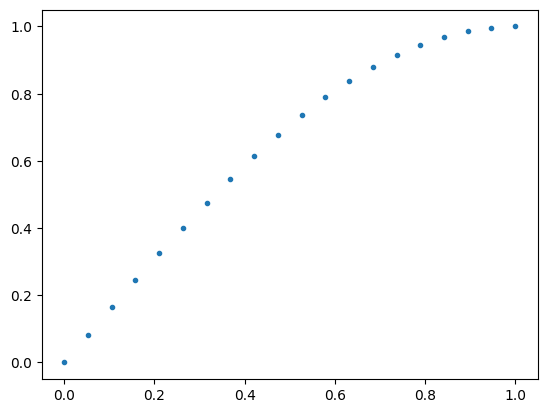

In [6]:
xss_ori = np.linspace(0, 0.5*np.pi, 100, dtype="double")

xss = sampledata.rescale_input_data(xss_ori, 1)
# The data set to approximate with x and y samples
xs_ori = np.linspace(xss_ori[0], xss_ori[-1], 20)
ys = np.array(np.sin(xs_ori))
#plt.plot(xs_ori, ys, '.')
xs = sampledata.rescale_input_data(xs_ori, 1)
plt.plot(xs, ys, '.')

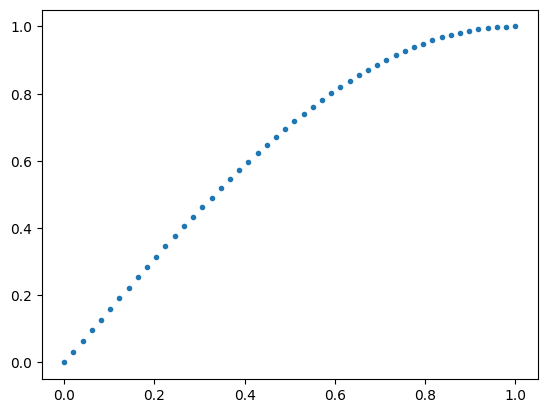

In [7]:
# The data set to approximate with x and y samples
xs2_ori = np.linspace(0, 0.5*np.pi, 50)
ys2 = np.sin(xs2_ori)
#plt.plot(xs2_ori, ys2, '.')
xs2 = sampledata.rescale_input_data(xs2_ori, 1)
plt.plot(xs2, ys2, '.')

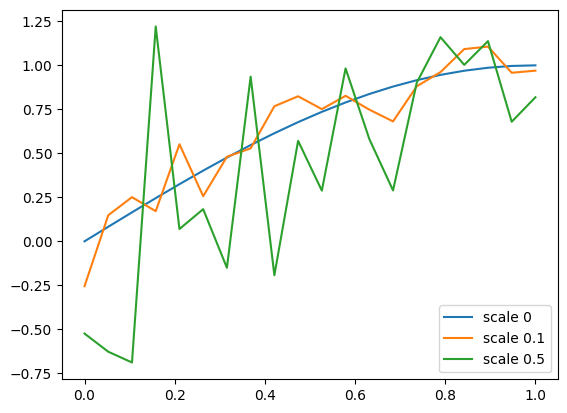

In [8]:
# Explicit seed to have reproducible testsets
np.random.seed(0)
ysgauss_scales = [0.0, 0.1, 0.5]
ysgauss = [ys + np.random.normal(scale=s, size=len(ys)) for s in ysgauss_scales]

for i, ysn in enumerate(ysgauss):
    plt.plot(xs, ysn, '-', label='scale %.2g' % ysgauss_scales[i])
plt.legend(loc="best")

## Investigating epochs and learning rates


In [9]:
epochs = 1000
degree = 5
lrs_ori = [10.0**e for e in np.arange(-2.0, 0.01, 0.25)]
lrs = [10.0**e for e in np.arange(-2.0, 1.25, 0.25)]

In [70]:
kwargs = {'data_x': xs, 'data_y': ys, 'degree': degree, 'polynum': no_segments, 'ck': 2, 'continuity': False,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'power', 'shift_polynomial_centers': 'mean', 'mode': 'learning_rate',
          'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [71]:
kwargs = {'data_x': xs, 'data_y': ys, 'degree': degree, 'polynum': no_segments, 'ck': 2, 'continuity': False,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'chebyshev', 'shift_polynomial_centers': 'mean', 'mode': 'learning_rate',
          'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [72]:
kwargs = {'data_x': xs, 'data_y': ys, 'degree': degree, 'polynum': no_segments, 'ck': 2, 'continuity': False,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'gradient_regularization': False,
          'basis': 'shifted_chebyshev', 'shift_polynomial_centers': 'boundary', 'mode': 'learning_rate',
          'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev = pool.starmap(parallel.job, zip(lrs, repeat(kwargs)))

In [73]:
# get total loss values of every entry

losses = [0.0] * len(results)
losses_chebyshev = [0.0] * len(results)
losses_shifted_chebyshev  = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]
    losses_chebyshev[i] = results_chebyshev[i][1]
    losses_shifted_chebyshev[i] = results_shifted_chebyshev[i][1]

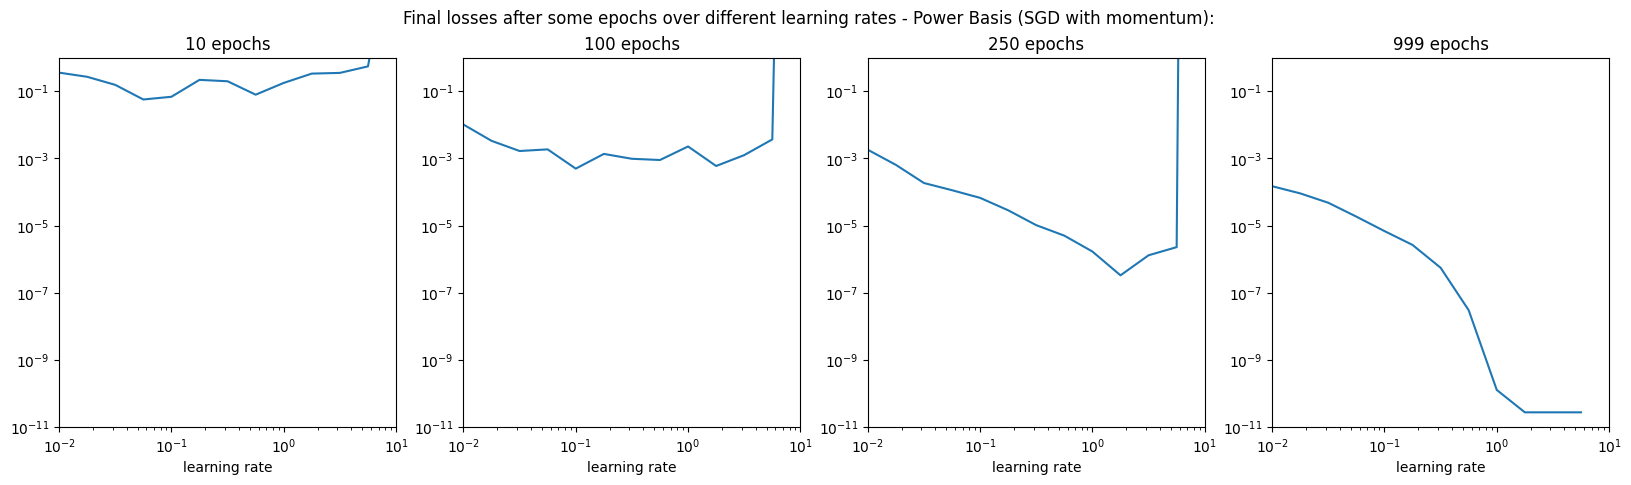

In [77]:
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.suptitle(f"Final losses after some epochs over different learning rates - Power Basis (SGD with momentum):")

for i, epochs in enumerate([10, 100, 250, 999]):
    ax = axes[i]
    
    ax.set_title("%d epochs" % epochs)
    
    ax.set_xlabel("learning rate")
    ax.loglog(lrs, [row[epochs] for row in losses])
    ax.set_xlim([1e-2, 1e1])
    ax.set_ylim([1e-11, 1e-0])

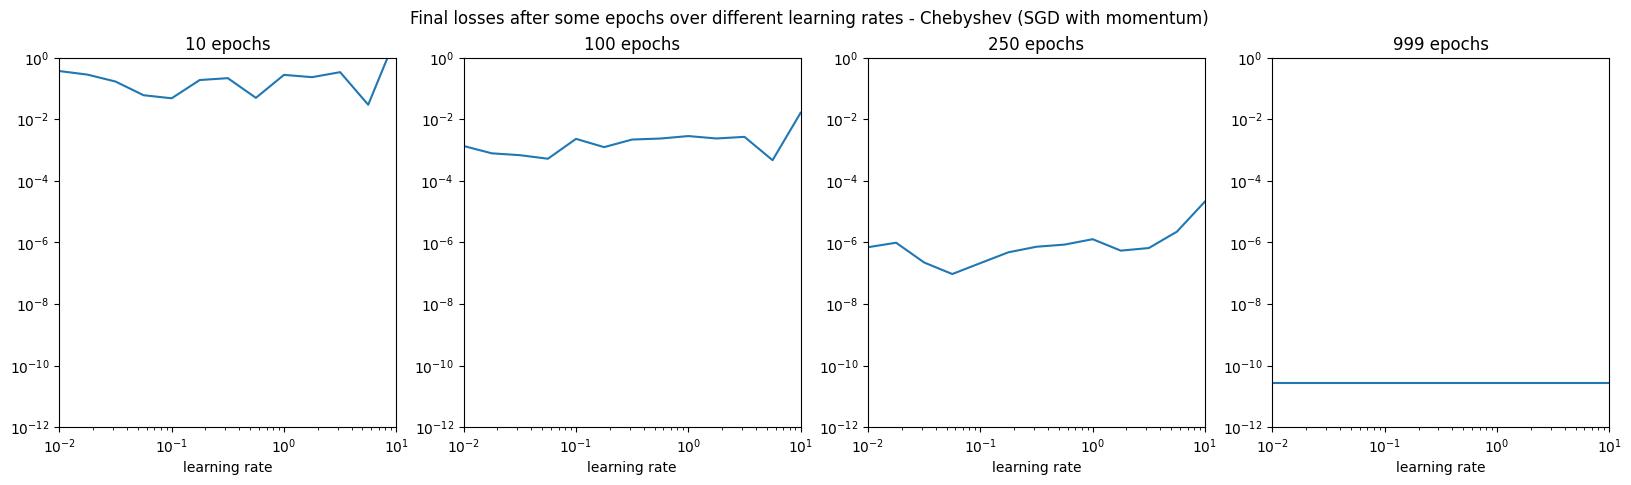

In [78]:
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.suptitle(f"Final losses after some epochs over different learning rates - Chebyshev (SGD with momentum)")

for i, epochs in enumerate([10, 100, 250, 999]):
    ax = axes[i]

    ax.set_title("%d epochs" % epochs)

    ax.set_xlabel("learning rate")
    ax.loglog(lrs, [row[epochs] for row in losses_chebyshev])
    ax.set_xlim([1e-2, 1e1])
    ax.set_ylim([1e-12, 1e-0])

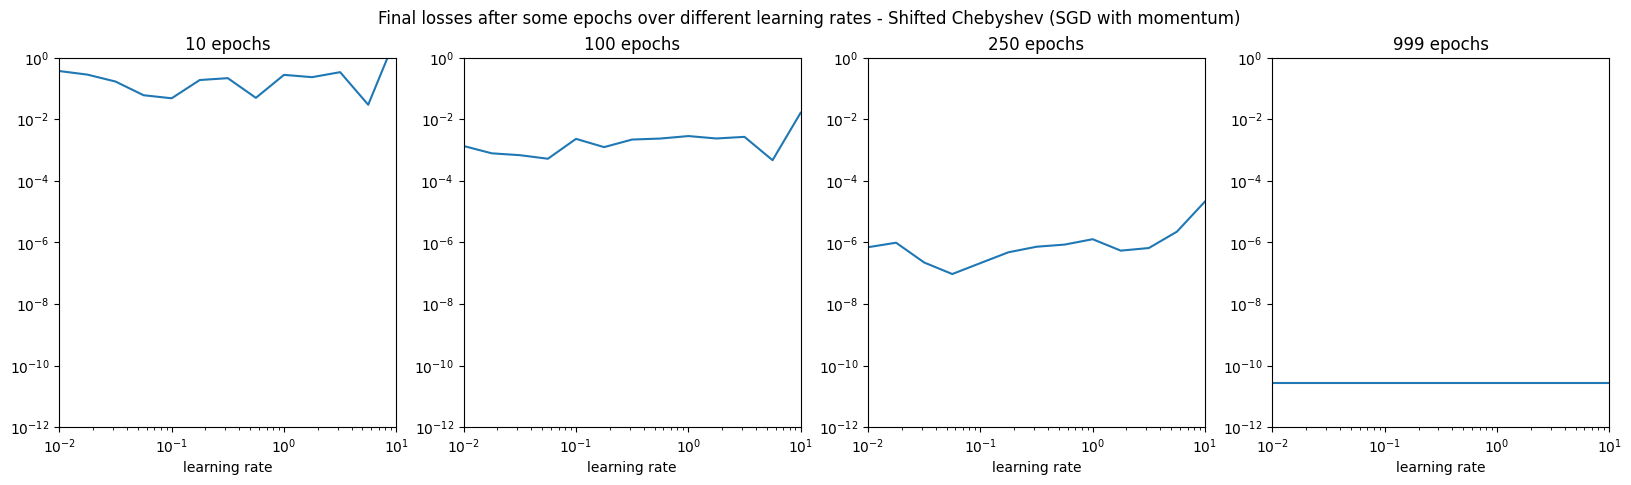

In [79]:
fig, axes = plt.subplots(1, 4)
fig.set_figwidth(20)
fig.suptitle(f"Final losses after some epochs over different learning rates - Shifted Chebyshev (SGD with momentum)")

for i, epochs in enumerate([10, 100, 250, 999]):
    ax = axes[i]

    ax.set_title("%d epochs" % epochs)

    ax.set_xlabel("learning rate")
    ax.loglog(lrs, [row[epochs] for row in losses_shifted_chebyshev])
    ax.set_xlim([1e-2, 1e1])
    ax.set_ylim([1e-12, 1e0])

### Interpretation
With 1000 epochs the result has settled, we can have high learning rates. In lower epochs, lower learning rates are beneficial.

**A learning rate of 1.0 with 1000 epochs seems to be a reasonable choice for all bases.**

## Investigating polynomial degree


In [80]:
epochs = 1000
lr = 1.0
degrees = [d for d in range(3, 10)]

In [81]:
kwargs = {'data_x': xs, 'data_y': ys, 'degree': degree, 'polynum': no_segments, 'ck': 2, 'continuity': False,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'learning_rate': lr, 'gradient_regularization': False,
        'basis': 'power', 'shift_polynomial_centers': 'mean', 'mode': 'degree',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [82]:
kwargs = {'data_x': xs, 'data_y': ys, 'degree': degree, 'polynum': no_segments, 'ck': 2, 'continuity': False,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'learning_rate': lr, 'gradient_regularization': False,
        'basis': 'chebyshev', 'shift_polynomial_centers': 'mean', 'mode': 'degree',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [83]:
kwargs = {'data_x': xs, 'data_y': ys, 'degree': degree, 'polynum': no_segments, 'ck': 2, 'continuity': False,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'learning_rate': lr, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'shift_polynomial_centers': 'boundary', 'mode': 'degree',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [85]:
splines = [0.0] * len(results)
splines_chebyshev = [0.0] * len(results)
splines_shifted_chebyshev  = [0.0] * len(results)

for i in range(len(results)):
    splines[i] = model.get_spline_from_coeffs(results[i][-1], xs, ys, basis='power', shift_polynomial_centers='mean', ck=2, total_loss_values=results[i][1])
    splines_chebyshev[i] = model.get_spline_from_coeffs(results_chebyshev[i][-1], xs, ys, basis='chebyshev', shift_polynomial_centers='mean', ck=2, total_loss_values=results_chebyshev[i][1])
    splines_shifted_chebyshev[i] = model.get_spline_from_coeffs(results_shifted_chebyshev[i][-1], xs, ys, basis='shifted_chebyshev', shift_polynomial_centers='boundary', ck=2, total_loss_values=results_shifted_chebyshev[i][1])

Text(0.5, 1.0, 'derivative 2')

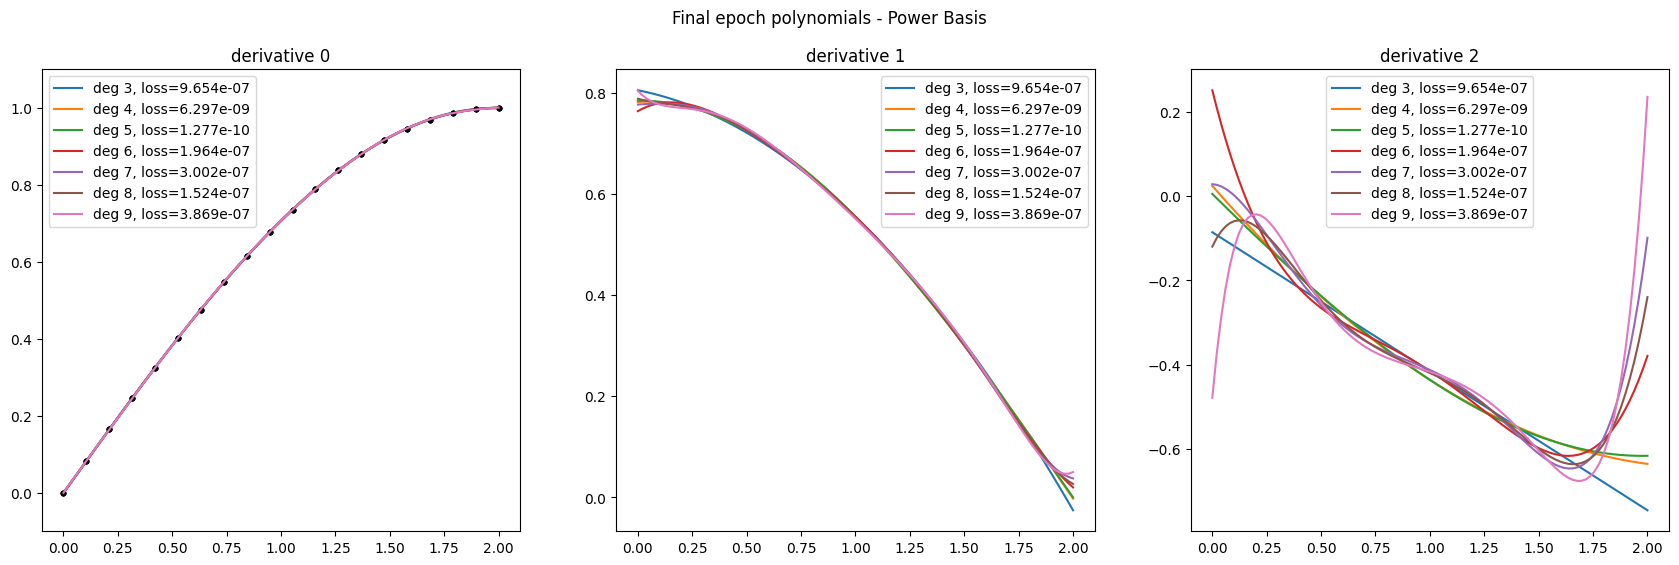

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(6)

for i, d in enumerate(degrees):
    sw = splines[i]
    plot.plot_spline(sw, ax=ax1, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False, color=colors[i])
    plot.plot_spline(sw, ax=ax2, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False, deriv=1, color=colors[i])
    plot.plot_spline(sw, ax=ax3, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False, deriv=2, color=colors[i])

fig.suptitle("Final epoch polynomials - Power Basis")
ax1.set_ylim((-0.1, 1.1))
ax1.legend(loc="best")
ax1.set_title("derivative 0")
ax2.legend(loc="best")
ax2.set_title("derivative 1")
ax3.legend(loc="best")
ax3.set_title("derivative 2")

Text(0.5, 1.0, 'derivative 2')

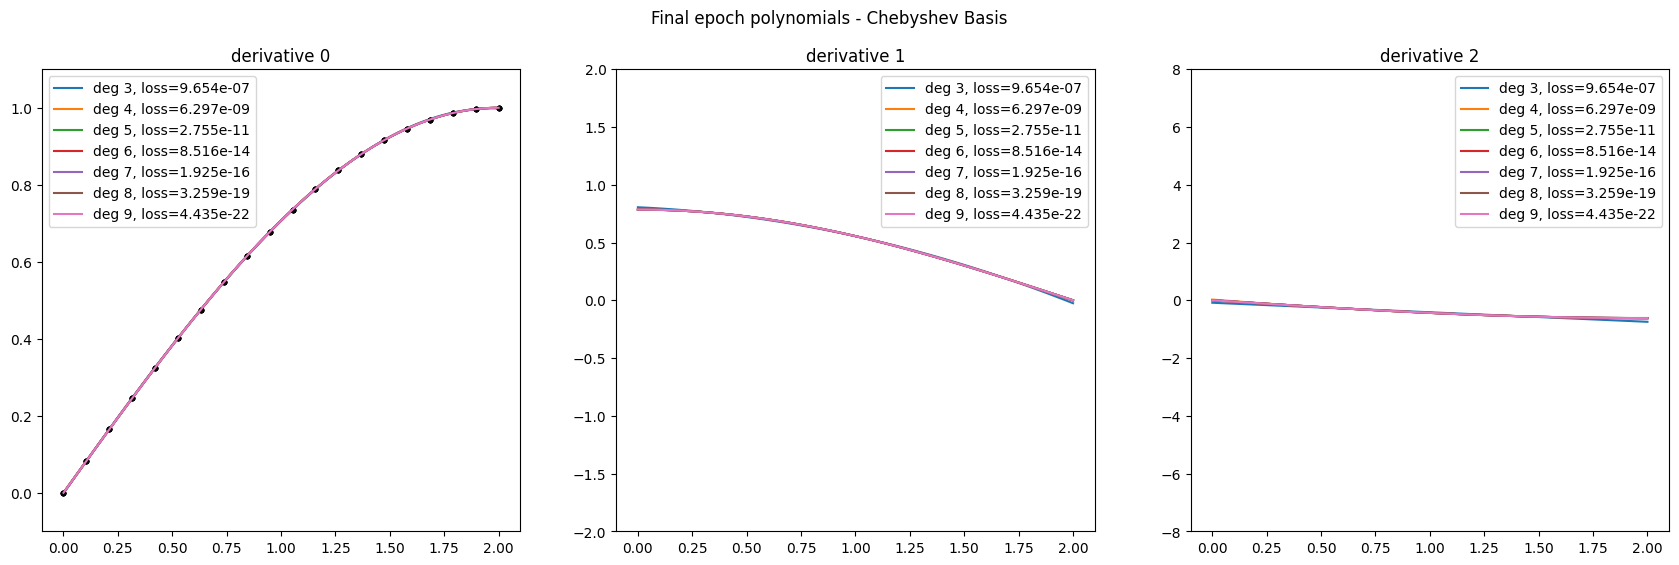

In [87]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(6)

for i, d in enumerate(degrees):
    sw = splines_chebyshev[i]
    plot.plot_spline(sw, ax=ax1, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False, color=colors[i])
    plot.plot_spline(sw, ax=ax2, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False, deriv=1, color=colors[i])
    plot.plot_spline(sw, ax=ax3, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False, deriv=2, color=colors[i])

fig.suptitle("Final epoch polynomials - Chebyshev Basis")
ax1.set_ylim((-0.1, 1.1))
ax1.legend(loc="best")
ax1.set_title("derivative 0")
ax2.set_ylim((-2, 2))
ax2.legend(loc="best")
ax2.set_title("derivative 1")
ax3.set_ylim((-8, 8))
ax3.legend(loc="best")
ax3.set_title("derivative 2")

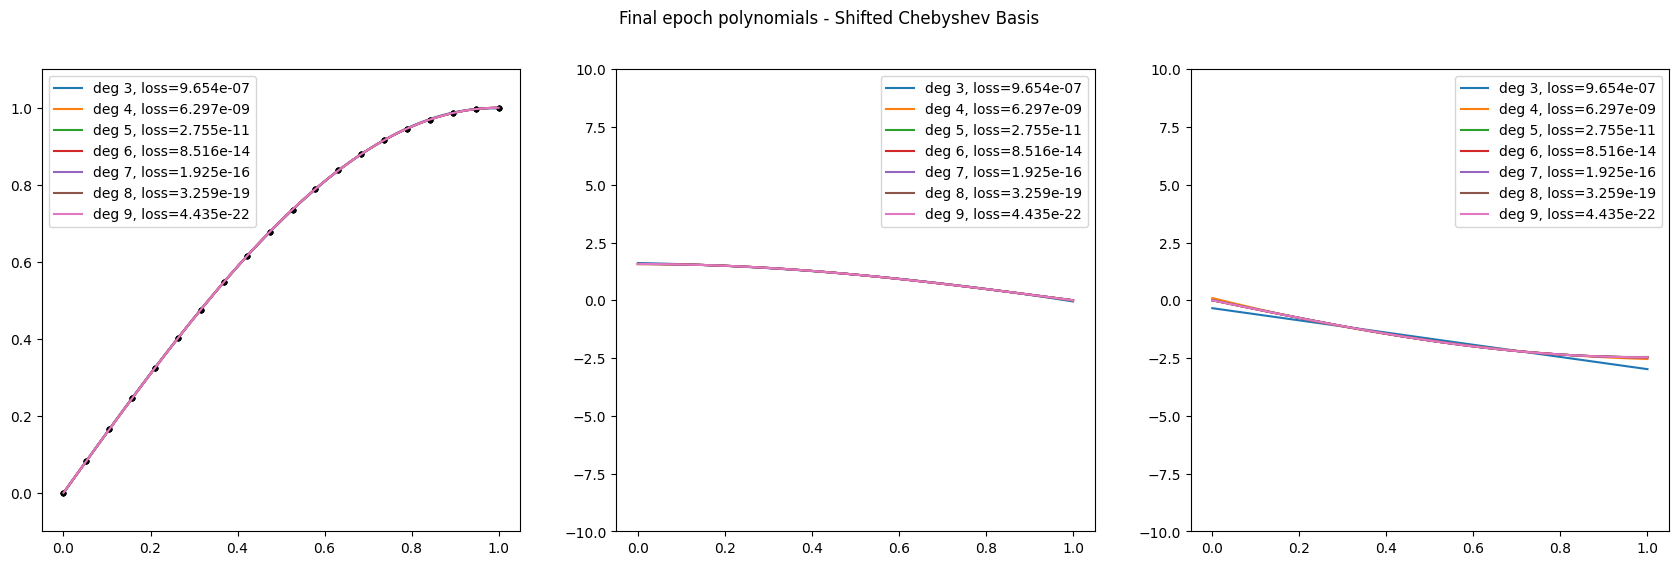

In [88]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(6)

for i, d in enumerate(degrees):
    sw = splines_shifted_chebyshev[i]
    plot.plot_spline(sw, ax=ax1, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False, color=colors[i])
    plot.plot_spline(sw, ax=ax2, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False, deriv=1, color=colors[i])
    plot.plot_spline(sw, ax=ax3, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False, deriv=2, color=colors[i])

fig.suptitle("Final epoch polynomials - Shifted Chebyshev Basis")
ax1.set_ylim((-0.1, 1.1))
ax1.legend(loc="best")
ax2.set_ylim((-10, 10))
ax2.legend(loc="best")
ax3.set_ylim((-10, 10))
ax3.legend(loc="best")

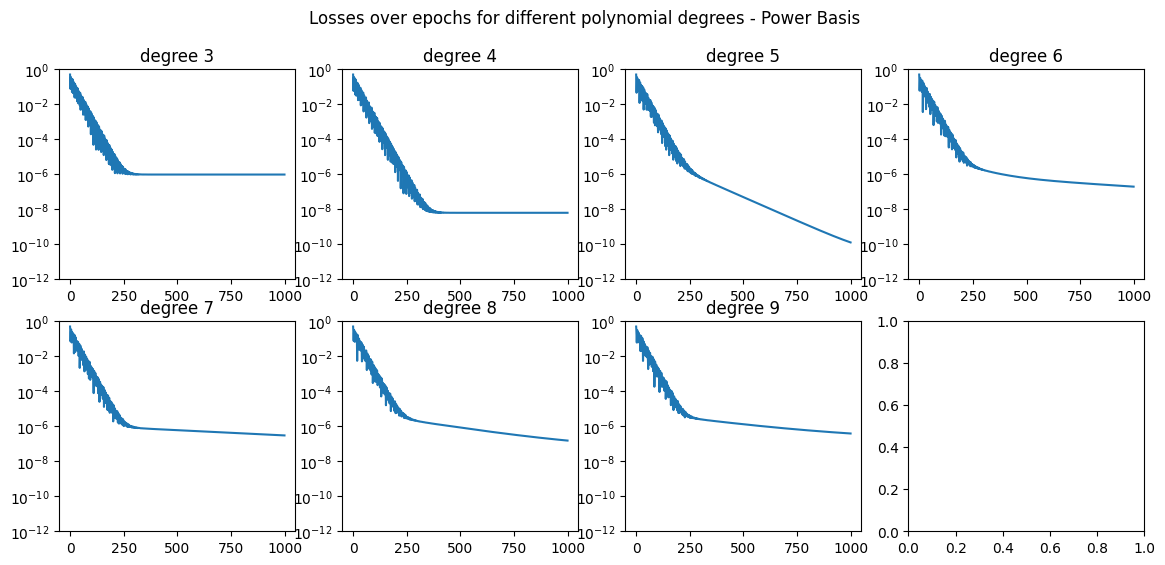

In [89]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over epochs for different polynomial degrees - Power Basis")

for i, d in enumerate(degrees):
    ax = axes[i]
    
    ax.set_title("degree %d" % d)
      
    ax.semilogy(splines[i].total_loss_values)
    ax.set_ylim([1e-12, 1e-0])

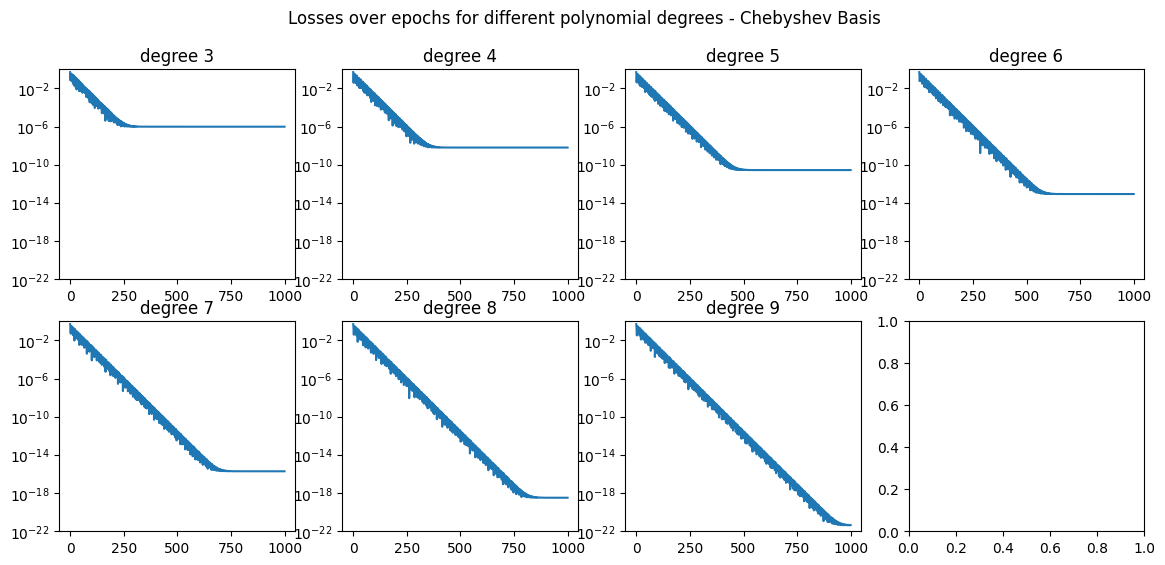

In [91]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over epochs for different polynomial degrees - Chebyshev Basis")

for i, d in enumerate(degrees):
    ax = axes[i]

    ax.set_title("degree %d" % d)

    ax.semilogy(splines_chebyshev[i].total_loss_values)
    ax.set_ylim([1e-22, 1e-0])

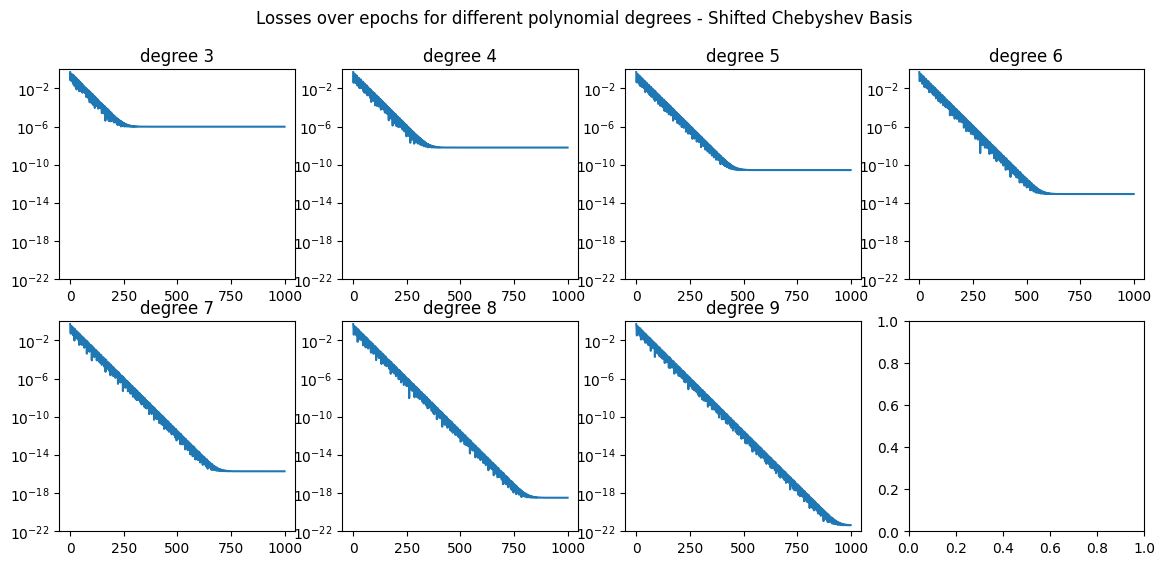

In [93]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over epochs for different polynomial degrees - Shifted Chebyshev Basis")

for i, d in enumerate(degrees):
    ax = axes[i]

    ax.set_title("degree %d" % d)

    ax.semilogy(splines_shifted_chebyshev[i].total_loss_values)
    ax.set_ylim([1e-22, 1e-0])

### Interpretation

With rising degree, the theoretically possible l2-optimum gets lower.
This is in accordance with Chebyshev and Shifted Chebyshev performance observed here,
these bases manage to converge to a lower loss with rising degree.
This is not the case for Power Basis. While performance with degree 5 is very good,
higher degrees perform worse.
As expected, higher degrees require more epochs to converge.
For Chebyshev and Shifted Chebyshev results converge for all degrees within 1000 epochs.
For Power basis degree 5 is competitive, but higher degrees require much more epochs.

In [94]:
epochs = 1000
degrees = range(3, 9)
lrs = [10.0**e for e in np.arange(-2.0, 1.25, 0.25)]
args = [(d, lr) for d in degrees for lr in lrs]

In [95]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': 2, 'continuity': False,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'power', 'shift_polynomial_centers': 'mean', 'mode': 'degree_and_learning_rate',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [96]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': 2, 'continuity': False,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'chebyshev', 'shift_polynomial_centers': 'mean', 'mode': 'degree_and_learning_rate',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [97]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': 2, 'continuity': False,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'shift_polynomial_centers': 'boundary', 'mode': 'degree_and_learning_rate',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [98]:
# Slice the outermost list into sublists of specific degrees
sliced_results = [results[i:i+len(lrs)] for i in range(0, len(results), len(lrs))]
sliced_results_chebyshev = [results_chebyshev[i:i+len(lrs)] for i in range(0, len(results_chebyshev), len(lrs))]
sliced_results_shifted_chebyshev = [results_shifted_chebyshev[i:i+len(lrs)] for i in range(0, len(results_shifted_chebyshev), len(lrs))]

# losses_with = [[0.0 for _ in range(len(lrs_ori))]] * len(sliced_results_with) # Bad! Creates Reference Copies of rows, thus duplicated rows in the end.
# losses_without = [[0.0 for _ in range(len(lrs_ori))]] * len(sliced_results_with)
losses = np.zeros((len(sliced_results), len(lrs)))
losses_chebyshev = np.zeros((len(sliced_results), len(lrs)))
losses_shifted_chebyshev = np.zeros((len(sliced_results), len(lrs)))

# We want the loss value at epoch 100 of the learning rate of every degree
for i in range(len(sliced_results)):
    for j in range(len(sliced_results[i])):
        losses[i][j] = sliced_results[i][j][1][-1]
        losses_chebyshev[i][j] = sliced_results_chebyshev[i][j][1][-1]
        losses_shifted_chebyshev[i][j] = sliced_results_shifted_chebyshev[i][j][1][-1]

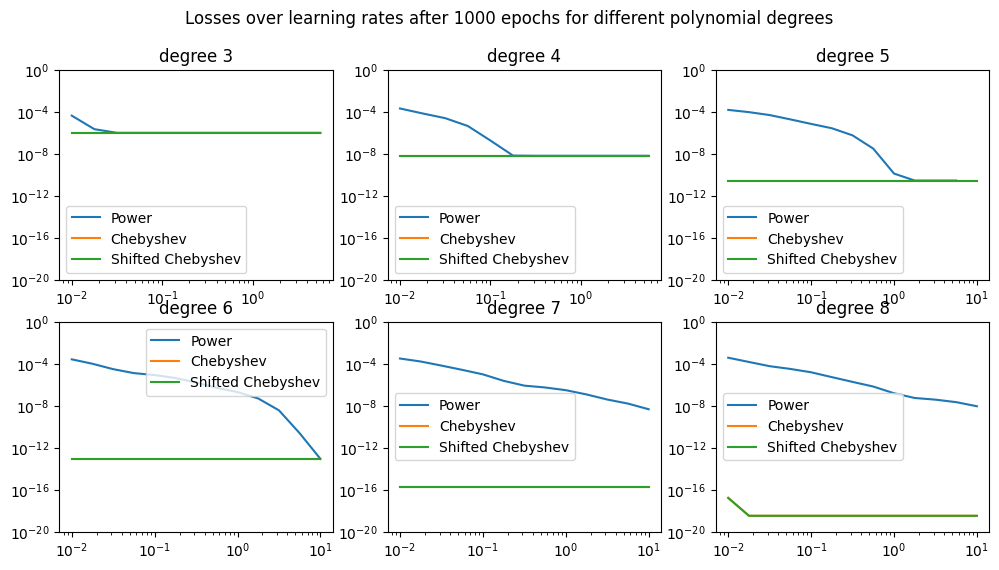

In [99]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over learning rates after %d epochs for different polynomial degrees" % epochs)

for i, d in enumerate(degrees):
    ax = axes[i]
    
    ax.set_title("degree %d" % d)
      
    ax.loglog(lrs, losses[i], label="Power")
    ax.loglog(lrs, losses_chebyshev[i], label="Chebyshev")
    ax.loglog(lrs, losses_shifted_chebyshev[i], label="Shifted Chebyshev")
    ax.set_ylim([1e-20, 1e-0])
    ax.legend(loc="best")

### Interpretation
For Power basis, higher learning rates may be benificial for higher degrees.
However, we cannot rise learning rates arbitrarily high, as results will diverge.
**For Chebyshev and Shifted Chebyshev basis, learning rate is independent of degree.**

In [117]:
lr = 12.0

In [118]:
kwargs = {'data_x': xs, 'data_y': ys, 'degree': degree, 'polynum': no_segments, 'ck': 2, 'continuity': False,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'learning_rate': lr, 'gradient_regularization': False,
        'basis': 'power', 'shift_polynomial_centers': 'mean', 'mode': 'degree',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [119]:
splines = [0.0] * len(results)
splines_chebyshev = [0.0] * len(results)
splines_shifted_chebyshev  = [0.0] * len(results)

for i in range(len(results)):
    splines[i] = model.get_spline_from_coeffs(results[i][-1], xs, ys, basis='power', shift_polynomial_centers='mean', ck=2, total_loss_values=results[i][1])
    splines_chebyshev[i] = model.get_spline_from_coeffs(results_chebyshev[i][-1], xs, ys, basis='chebyshev', shift_polynomial_centers='mean', ck=2, total_loss_values=results_chebyshev[i][1])
    splines_shifted_chebyshev[i] = model.get_spline_from_coeffs(results_shifted_chebyshev[i][-1], xs, ys, basis='shifted_chebyshev', shift_polynomial_centers='boundary', ck=2, total_loss_values=results_shifted_chebyshev[i][1])

Text(0.5, 1.0, 'derivative 2')

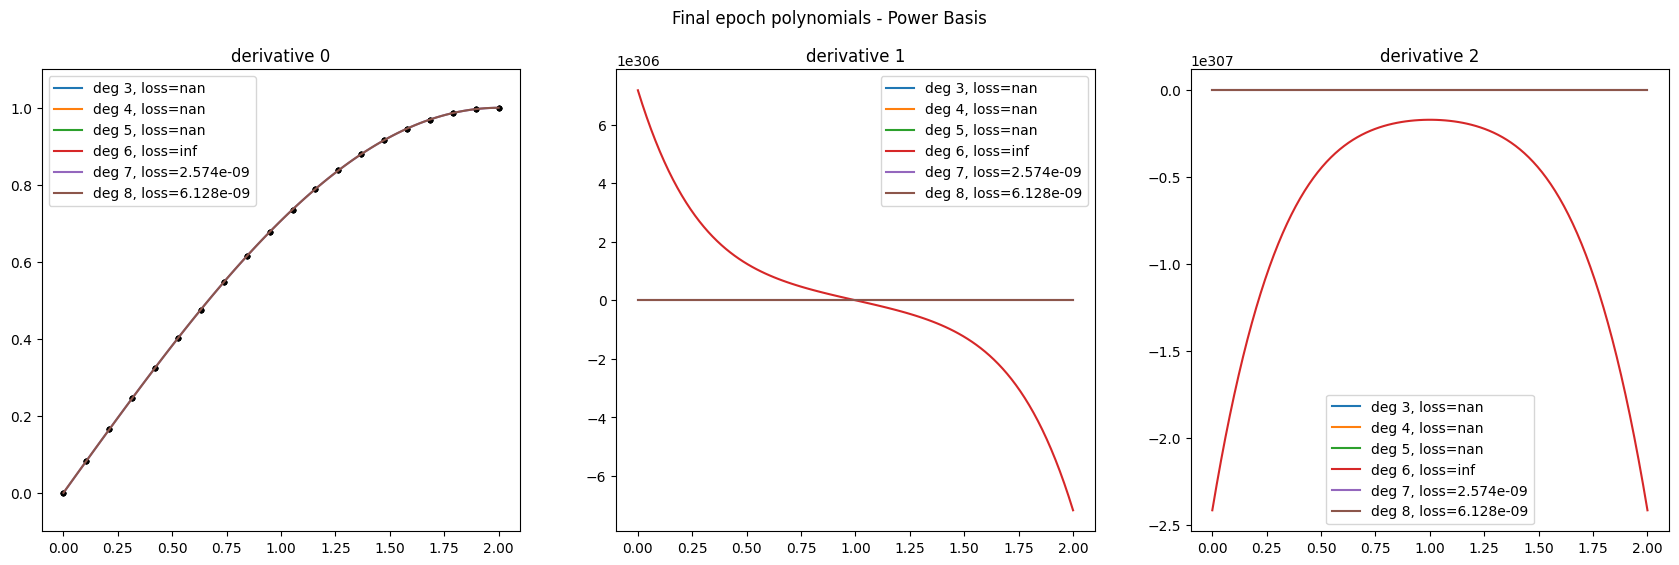

In [120]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.set_figheight(6)

for i, d in enumerate(degrees):
    sw = splines[i]
    plot.plot_spline(sw, ax=ax1, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False, color=colors[i])
    plot.plot_spline(sw, ax=ax2, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False, deriv=1, color=colors[i])
    plot.plot_spline(sw, ax=ax3, label=f'deg {sw.polydegree}, loss={sw.total_loss_values[-1]:.4g}', segment_coloring=False, deriv=2, color=colors[i])

fig.suptitle("Final epoch polynomials - Power Basis")
ax1.set_ylim((-0.1, 1.1))
ax1.legend(loc="best")
ax1.set_title("derivative 0")
ax2.legend(loc="best")
ax2.set_title("derivative 1")
ax3.legend(loc="best")
ax3.set_title("derivative 2")

C:\Users\Hannes Waclawek\Documents\FH Git Repos\venvs\experiments-chebyshev-legendre\lib\site-packages\matplotlib\scale.py:253: RuntimeWarning: overflow encountered in power
  return np.power(self.base, a)


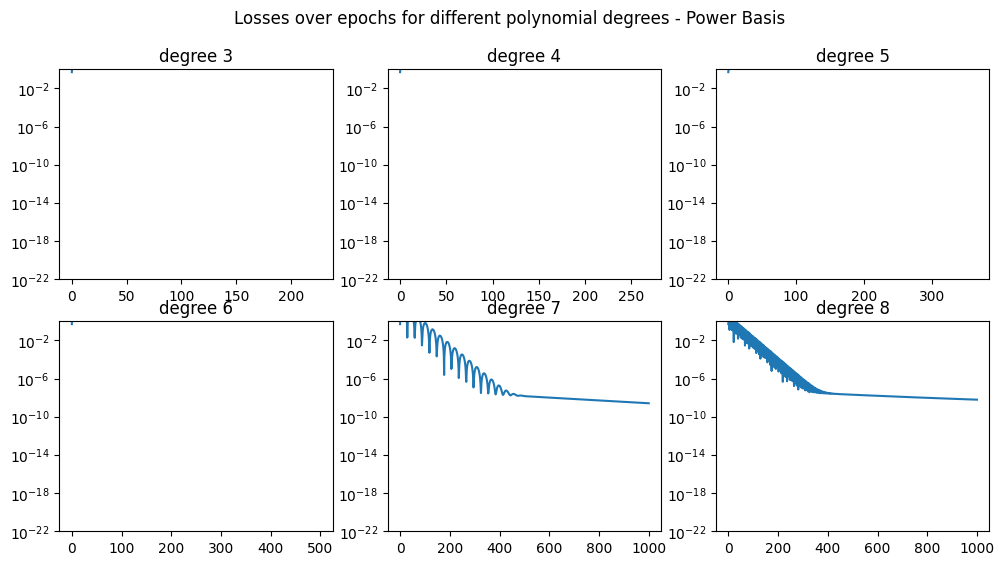

In [121]:
fig, axes = plt.subplots(2, (len(degrees) + 1)//2)
axes = axes.flatten()
fig.set_figwidth(len(degrees)*2)
fig.set_figheight(6)
fig.suptitle("Losses over epochs for different polynomial degrees - Power Basis")

for i, d in enumerate(degrees):
    ax = axes[i]
    
    ax.set_title("degree %d" % d)
      
    ax.semilogy(splines[i].total_loss_values)
    ax.set_ylim([1e-22, 1e-0])

## Investigating number of input points

In [122]:
lr = 1.0
epochs = 1000
degrees = [d for d in range(3, 9)]

In [123]:
kwargs = {'data_x': xs2, 'data_y': ys2, 'polynum': no_segments, 'ck': ck, 'continuity': False,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'learning_rate': learning_rate , 'mode': 'degree',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [124]:
kwargs = {'data_x': xs2, 'data_y': ys2, 'polynum': no_segments, 'ck': ck, 'continuity': False,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'learning_rate': learning_rate , 'mode': 'degree',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [125]:
kwargs = {'data_x': xs2, 'data_y': ys2, 'polynum': no_segments, 'ck': ck, 'continuity': False,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'shift_polynomial_centers': shift_polynomial_centers_sc, 'learning_rate': learning_rate , 'mode': 'degree',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev = pool.starmap(parallel.job, zip(degrees, repeat(kwargs)))

In [127]:
splines = [0.0] * len(results)
splines_chebyshev = [0.0] * len(results)
splines_shifted_chebyshev  = [0.0] * len(results)

for i in range(len(results)):
    splines[i] = model.get_spline_from_coeffs(results[i][-1], xs2, ys2, basis='power', shift_polynomial_centers=shift_polynomial_centers, ck=ck, total_loss_values=results[i][1])
    splines_chebyshev[i] = model.get_spline_from_coeffs(results_chebyshev[i][-1], xs2, ys2, basis='chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=ck, total_loss_values=results_chebyshev[i][1])
    splines_shifted_chebyshev[i] = model.get_spline_from_coeffs(results_shifted_chebyshev[i][-1], xs2, ys2, basis='shifted_chebyshev', shift_polynomial_centers=shift_polynomial_centers_sc, ck=ck, total_loss_values=results_shifted_chebyshev[i][1])

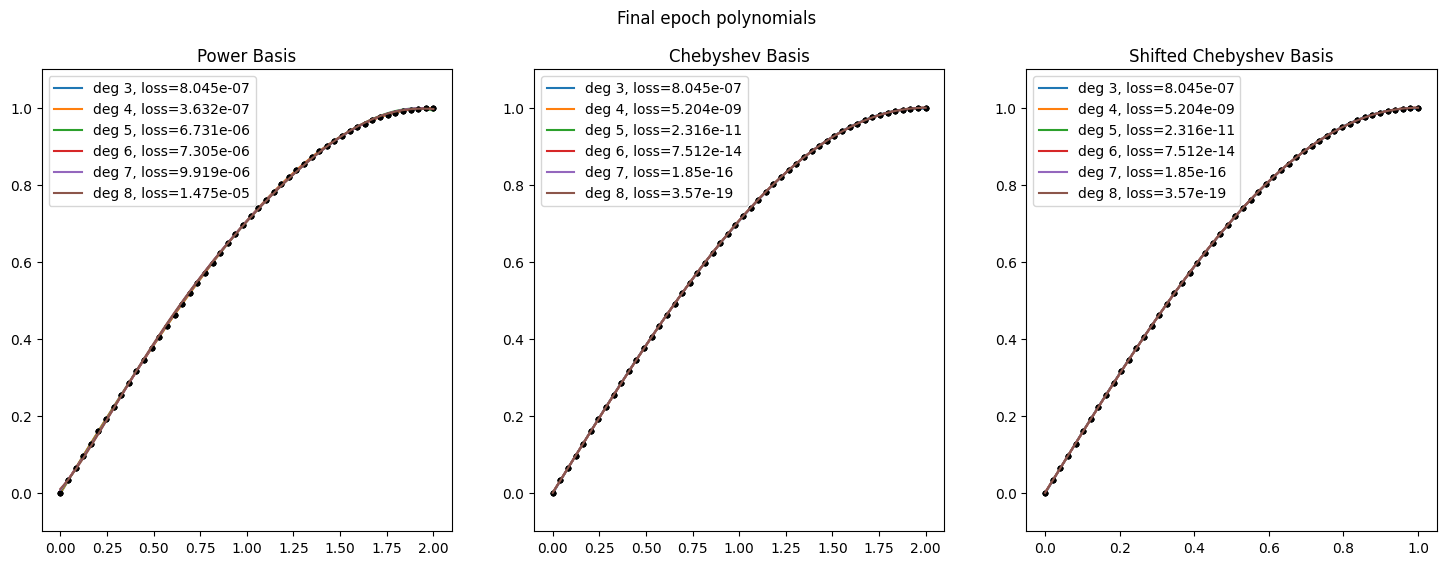

In [128]:
fig, (ax1,ax2,ax3) = plt.subplots(1, 3)
fig.set_figwidth(18)
fig.set_figheight(6)

for i, d in enumerate(degrees):
    s = splines[i]
    sc = splines_chebyshev[i]
    ssc = splines_shifted_chebyshev[i]
    plot.plot_spline(s, ax=ax1, label=f'deg {s.polydegree}, loss={s.total_loss_values[-1]:.4g}', segment_coloring=False, color=colors[i])
    plot.plot_spline(sc, ax=ax2, label=f'deg {sc.polydegree}, loss={sc.total_loss_values[-1]:.4g}', segment_coloring=False, color=colors[i])
    plot.plot_spline(ssc, ax=ax3, label=f'deg {ssc.polydegree}, loss={ssc.total_loss_values[-1]:.4g}', segment_coloring=False, color=colors[i])

fig.suptitle("Final epoch polynomials")
ax1.set_title("Power Basis")
ax2.set_title("Chebyshev Basis")
ax3.set_title("Shifted Chebyshev Basis")
ax1.set_ylim((-0.1, 1.1))
ax2.set_ylim((-0.1, 1.1))
ax3.set_ylim((-0.1, 1.1))
ax1.legend(loc="best")
ax2.legend(loc="best")
ax3.legend(loc="best")

### Interpretation

With all observed bases the effect is mild.

In [135]:
epochs = 1000
degree = 7
numpoints = [20, 40, 60, 80, 100]
lrs = [10.0**e for e in np.arange(-2.0, 1.0, 0.25)]
#lrs = [10.0**e for e in np.arange(-2.0, 0.01, 0.25)]
args = [(n, lr) for n in numpoints for lr in lrs]

In [136]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': ck, 'continuity': False, 'degree': degree,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'learning_rate': learning_rate , 'mode': 'numpoints_and_learning_rate',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [137]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': ck, 'continuity': False, 'degree': degree,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'learning_rate': learning_rate , 'mode': 'numpoints_and_learning_rate',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [138]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': ck, 'continuity': False, 'degree': degree,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'shift_polynomial_centers': shift_polynomial_centers_sc, 'learning_rate': learning_rate , 'mode': 'numpoints_and_learning_rate',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev = pool.starmap(parallel.job, zip(args, repeat(kwargs)))

In [139]:
# Slice the outermost list into sublists of specific degrees
sliced_results = [results[i:i+len(lrs)] for i in range(0, len(results), len(lrs))]
sliced_results_chebyshev = [results_chebyshev[i:i+len(lrs)] for i in range(0, len(results_chebyshev), len(lrs))]
sliced_results_shifted_chebyshev = [results_shifted_chebyshev[i:i+len(lrs)] for i in range(0, len(results_shifted_chebyshev), len(lrs))]

# losses_with = [[0.0 for _ in range(len(lrs_ori))]] * len(sliced_results_with) # Bad! Creates Reference Copies of rows, thus duplicated rows in the end.
# losses_without = [[0.0 for _ in range(len(lrs_ori))]] * len(sliced_results_with)
losses = np.zeros((len(sliced_results), len(lrs)))
losses_chebyshev = np.zeros((len(sliced_results), len(lrs)))
losses_shifted_chebyshev = np.zeros((len(sliced_results), len(lrs)))

# We want the loss value at epoch 100 of the learning rate of every degree
for i in range(len(sliced_results)):
    for j in range(len(sliced_results[i])):
        losses[i][j] = sliced_results[i][j][1][-1]
        losses_chebyshev[i][j] = sliced_results_chebyshev[i][j][1][-1]
        losses_shifted_chebyshev[i][j] = sliced_results_shifted_chebyshev[i][j][1][-1]

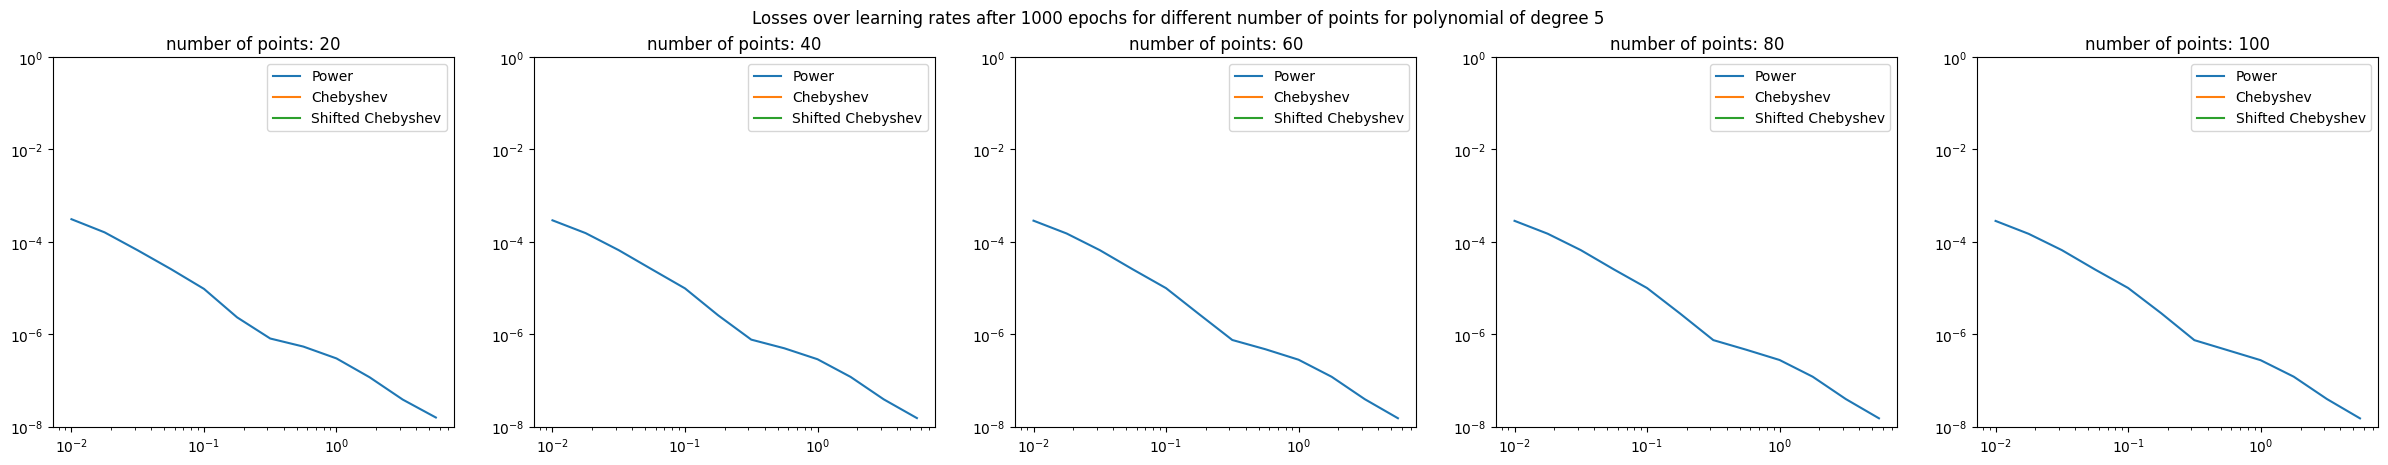

In [140]:
fig, axes = plt.subplots(1, len(numpoints))
axes = axes.flatten()
fig.set_figwidth(len(numpoints)*6)
#fig.set_figheight(6)
fig.suptitle("Losses over learning rates after %d epochs for different number of points for polynomial of degree 5" % epochs)

for i, d in enumerate(numpoints):
    ax = axes[i]

    ax.set_title("number of points: %d" % d)

    ax.loglog(lrs, losses[i], label="Power")
    ax.loglog(lrs, losses_chebyshev[i], label="Chebyshev")
    ax.loglog(lrs, losses_shifted_chebyshev[i], label="Shifted Chebyshev")
    ax.set_ylim([1e-8, 1e-0])
    ax.legend(loc="best")

### Interpretation

Raising the number of points has almost no effect to the highest learning rate we can achieve.
Of course, the number of points has to be sufficiently high for a degree for a well-conditioned fit in the first place.

## Fixing Degree and learning rate

Since we require minimum degree 7 for strictly establishing continuity per algorithm and this degree shows favourable results with Chebyshev basis, we continue further experiments with this degree.
A learning rate of 1.0 seems feasible for all bases.

In [10]:
learning_rate = 1.0
degree = 7
factor_approximation_quality = 1
factor_ck_pressure = 0
no_segments = 1

## Investigating optimizers

In [11]:
epochs = 5000
optimizers = ['sgd', 'sgd-momentum', 'sgd-momentum-nesterov', 'adagrad', 'adadelta', 'rmsprop', 'adam', 'adamax', 'nadam', 'adam-amsgrad', 'adafactor', 'adamw', 'ftrl', 'lion']

In [12]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': ck, 'continuity': False, 'degree': degree,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': ck, 'continuity': False, 'degree': degree,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': ck, 'continuity': False, 'degree': degree,
        'optimizer': 'SGD-MOMENTUM', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'shift_polynomial_centers': shift_polynomial_centers_sc, 'learning_rate': learning_rate , 'mode': 'optimizers',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev = pool.starmap(parallel.job, zip(optimizers, repeat(kwargs)))

In [13]:
# get total loss values of every entry
losses = [0.0] * len(results)
losses_chebyshev = [0.0] * len(results)
losses_shifted_chebyshev  = [0.0] * len(results)

for i in range(len(results)):
    losses[i] = results[i][1]
    losses_chebyshev[i] = results_chebyshev[i][1]
    losses_shifted_chebyshev[i] = results_shifted_chebyshev[i][1]

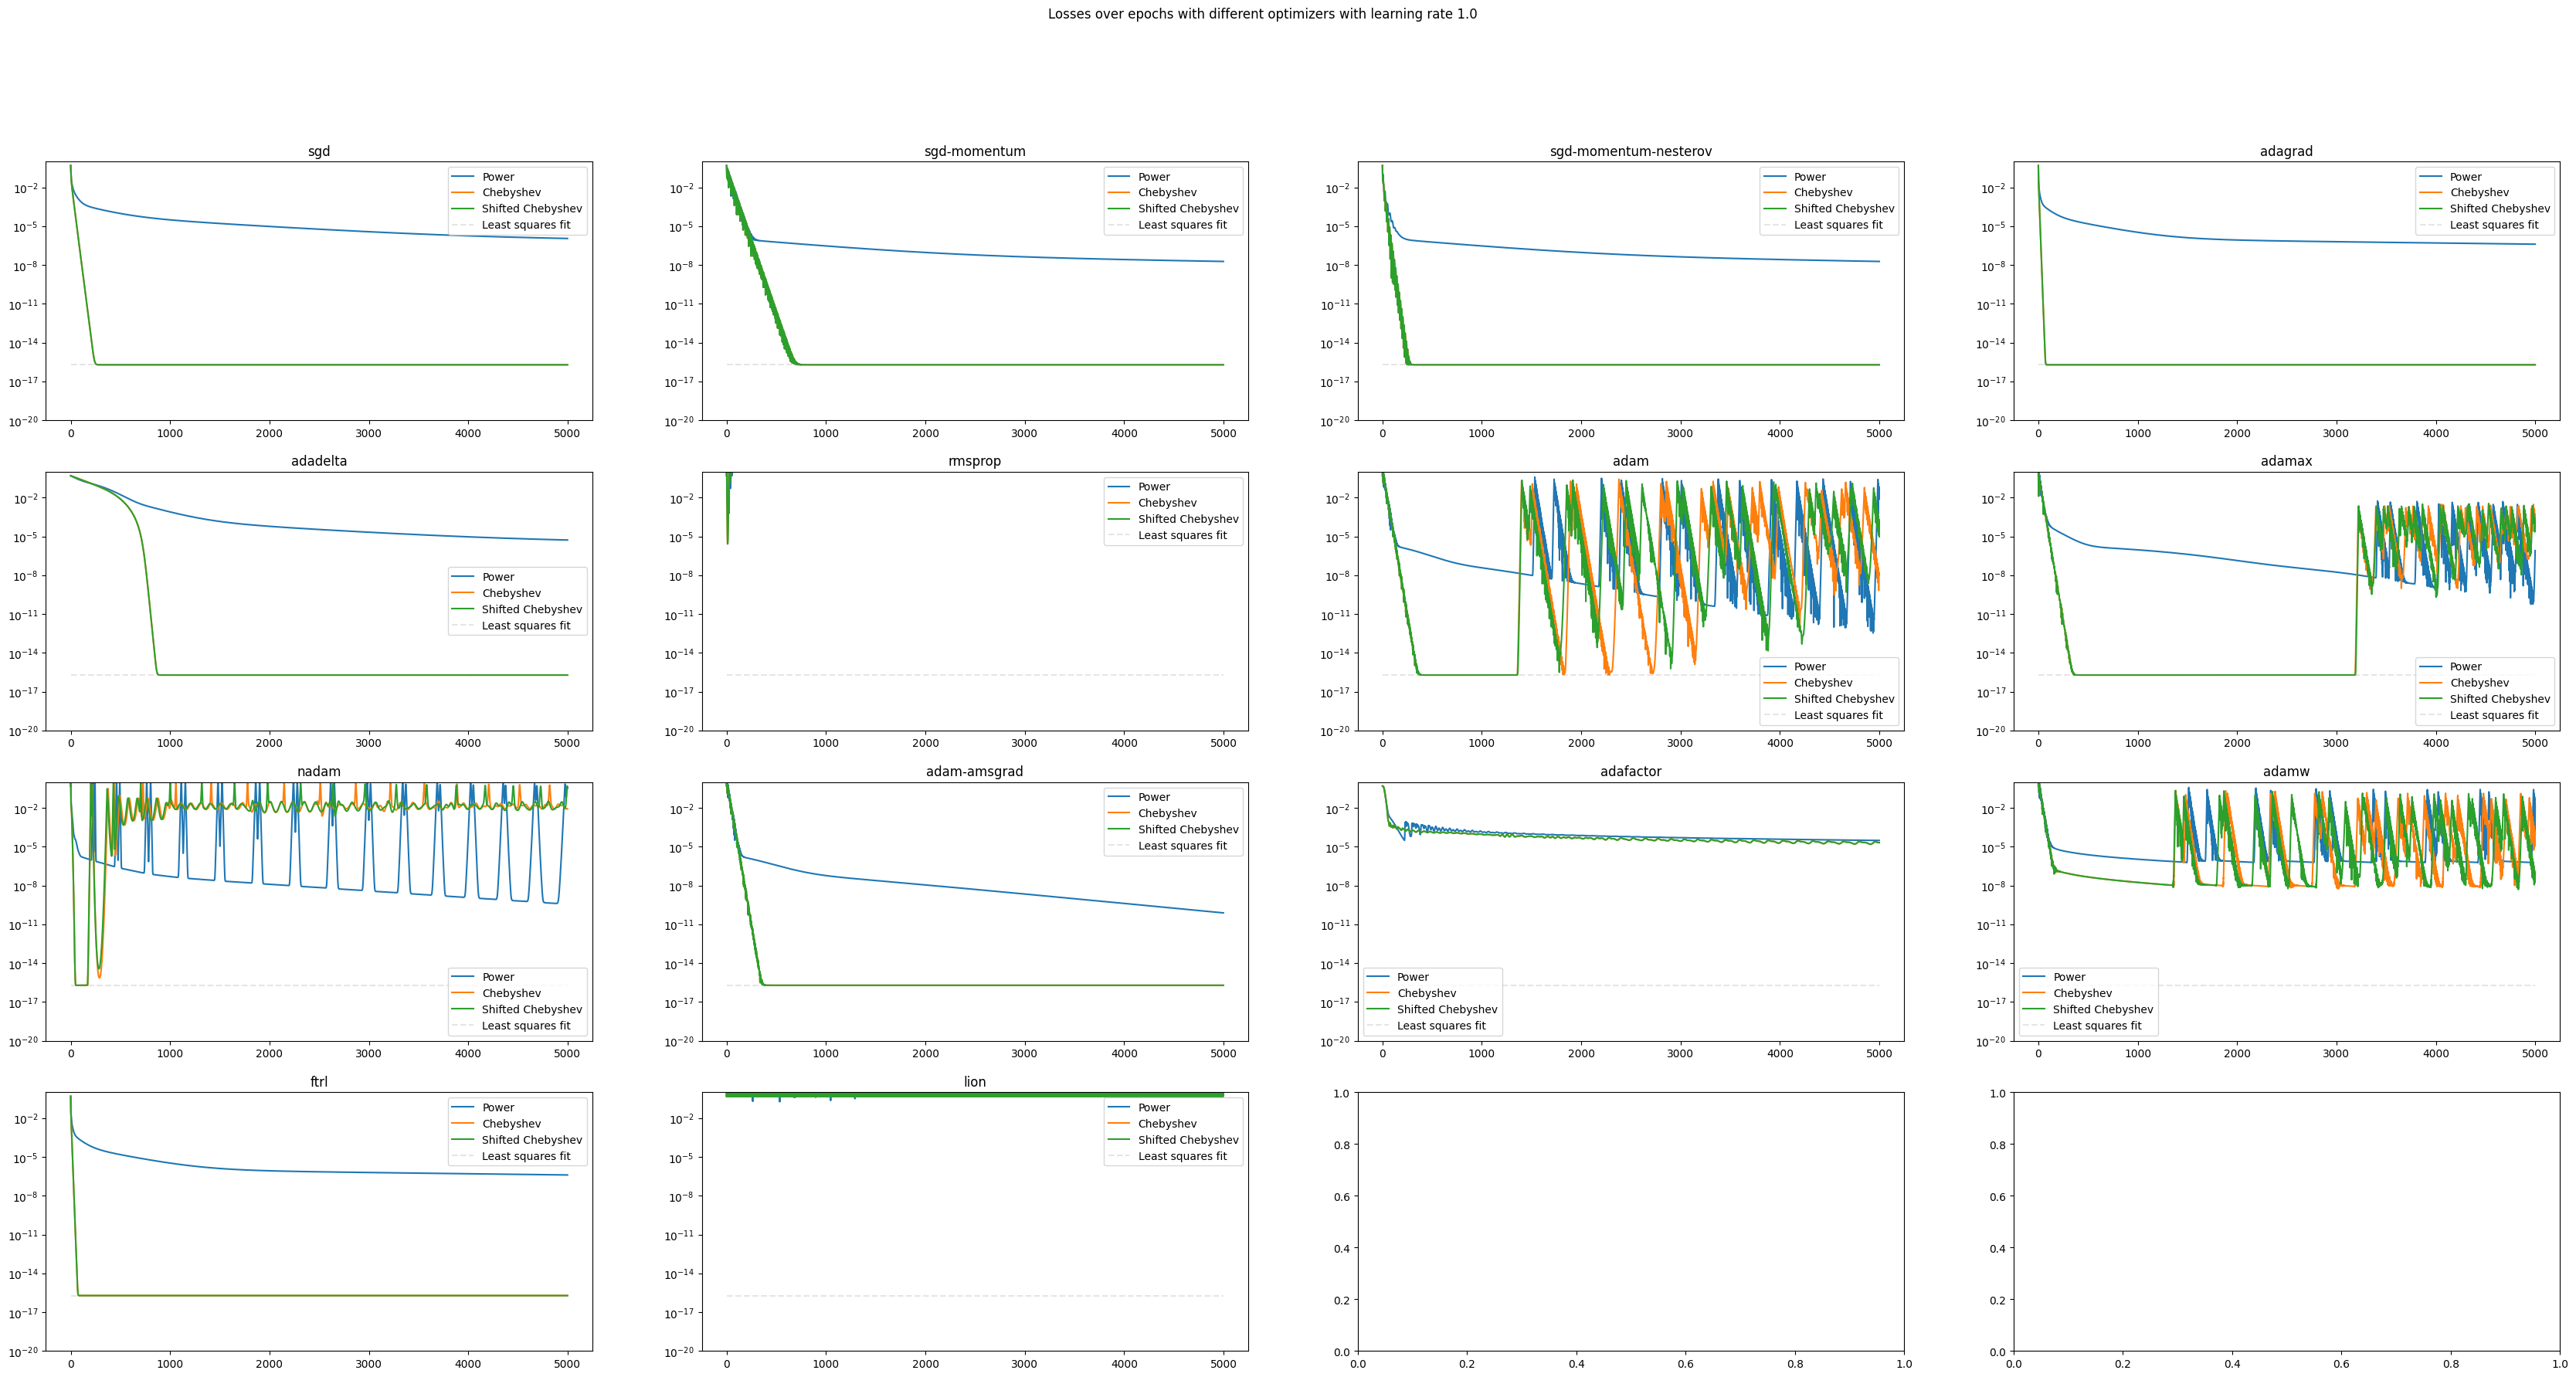

In [18]:
fig, axes = plt.subplots(4, (len(optimizers)+2)//4) 
axes = axes.flatten()
fig.set_figwidth(len(optimizers)*3)
fig.set_figheight(20)
fig.suptitle(f'Losses over epochs with different optimizers with learning rate 1.0')

spline = model.Spline(degree, no_segments, ck, 'chebyshev')
spline.fit(xs, ys, epochs=1)
optimum = plot.get_l2_baseline_error(spline, ck_loss = True, ck = ck)

for i, opt in enumerate(optimizers):
    ax = axes[i]

    ax.set_title("%s" % opt)

    ax.semilogy(losses[i], label="Power")
    ax.semilogy(losses_chebyshev[i], label="Chebyshev")
    ax.semilogy(losses_shifted_chebyshev[i], label="Shifted Chebyshev")
    ax.hlines(optimum[0], xmin=0, xmax=epochs, color='gray', linestyle="--", alpha=0.2, label="Least squares fit")
    ax.set_ylim([1e-20, 1e-0])
    ax.legend(loc="best")

### Interpretation
Chebyshev and Shifted chebyshev is performing (almost) identically and clearly outperforming Power Basis in regard to all observed optimizers.
**None of the optimizers manage to reach the l2 optimum with Power basis in the given 5000 epochs.**
**There are, however, several optimizers that achieve this with Chebyshev basis.** Quickest convergence:
1. nadam, adagrad, ftrl
2. Vanilla SGD, SGD with Nesterov momentum, adam, adamax, amsgrad
3. SGD with momentum, adadelta

We don't consider stability after reaching the optimum, as early stopping is an option.
As our main goal is performing combined approximation and continuity optimization in the next Jupyter notebook,
we don't look into optimizing hyerparameters of individual optimizers here.

## Stability under noise for AMSGrad

The following 4 functions were taken from Stefan Huber's "polynomial.py", <stefan.huber@fh-salzburg.ac.at>.

In [149]:
def evaluate(coeffs, x):
    """Return evaluation of a polynomial with given coefficients at location x.
    If coeffs is [a, b, c, …] then return a + b·x + c·x² + …"""

    tot = 0.0
    for c in coeffs[::-1]:
        tot = x*tot + c
    return tot

In [150]:
def evaluate_vect(coeffs, xs):
    """Like a vectorized version of evaluate() for lists of values for x."""

    # We cannot use numpy.vectorize here because it would stop gradient
    # computation.
    # Note that tf.vectorize_map() is slow because len(xs) is too small
    # to pay off, I guess. Using map_fn() is similarily fast than using
    # plain list comprehension.
    return [evaluate(coeffs, x) for x in xs]

In [151]:
def l2_sq_error(coeffs, xs, ys):
    """Returns the square of the L2-error between polynomial of given coeffs
    and the samples given in ys at loctions xs. That is, if the polynomial
    given by coeffs is p then return the sum of the squares of p(x)-y where x,
    y iterates over xs, ys."""

    fs = evaluate_vect(coeffs, xs)
    ds = tf.subtract(fs, ys)
    return tf.reduce_sum(tf.multiply(ds, ds))

In [152]:
def l2_sq_loss(coeffs, xs, ys):
    """The squared L2 loss of given polynomial on given data points (xs, ys).␣
    ,→Loss is
    invariant on the length of xs."""
    return l2_sq_error(coeffs, xs, ys) / len(xs)

In [153]:
epochs = 1000

In [154]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': ck, 'continuity': False, 'degree': degree,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'learning_rate': learning_rate , 'mode': 'data_y',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(ysgauss, repeat(kwargs)))

kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': ck, 'continuity': False, 'degree': degree,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'learning_rate': learning_rate , 'mode': 'data_y',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(ysgauss, repeat(kwargs)))

kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': ck, 'continuity': False, 'degree': degree,
        'optimizer': 'AMSGrad', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'shift_polynomial_centers': shift_polynomial_centers_sc, 'learning_rate': learning_rate , 'mode': 'data_y',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev = pool.starmap(parallel.job, zip(ysgauss, repeat(kwargs)))

In [157]:
splines = [0.0] * len(results)
splines_chebyshev = [0.0] * len(results)
splines_shifted_chebyshev = [0.0] * len(results)

for i in range(len(results)):
    splines[i] = model.get_spline_from_coeffs(results[i][-1], xs, ysgauss[i], basis='power', shift_polynomial_centers=shift_polynomial_centers, ck=0, total_loss_values=results[i][1])
    splines_chebyshev[i] = model.get_spline_from_coeffs(results_chebyshev[i][-1], xs, ysgauss[i], basis='chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=0, total_loss_values=results_chebyshev[i][1])
    splines_shifted_chebyshev[i] = model.get_spline_from_coeffs(results_shifted_chebyshev[i][-1], xs, ysgauss[i], basis='shifted_chebyshev', shift_polynomial_centers=shift_polynomial_centers_sc, ck=0,  total_loss_values=results_shifted_chebyshev[i][1])

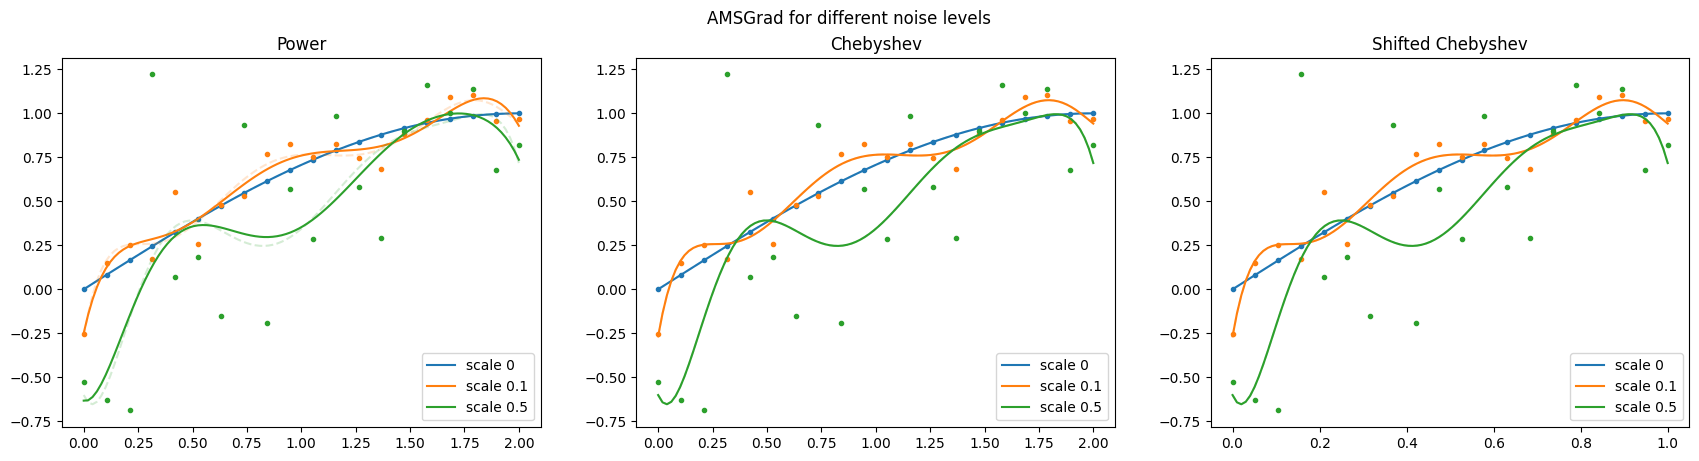

In [158]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.suptitle("AMSGrad for different noise levels")
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

for i in range(len(splines)):
    col = next(colcycle)["color"]
    ps = splines[i].evaluate_spline_at_x(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_POWER))
    psc = splines_chebyshev[i].evaluate_spline_at_x(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_CHEBYSHEV))
    pssc = splines_shifted_chebyshev[i].evaluate_spline_at_x(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV))
    ysg = ysgauss[i]
    scale = ysgauss_scales[i]
    
    optcoeff = np.polyfit(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_POWER), ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_POWER)]
    optloss = l2_sq_loss(optcoeff, sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_POWER), ysg)
        
    ax1.plot(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_POWER), ysg, '.', c=col)
    ax1.plot(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_POWER), ps, label="scale %.2g" % scale, c=col)
    ax1.plot(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_POWER), psopt, c=col, linestyle="--", alpha=0.2) 
 
    optcoeff = np.polyfit(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_CHEBYSHEV), ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_CHEBYSHEV)]
    optloss = l2_sq_loss(optcoeff, sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_CHEBYSHEV), ysg)
    
    ax2.plot(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_CHEBYSHEV), ysg, '.', c=col)
    ax2.plot(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_CHEBYSHEV), psc, label="scale %.2g" % scale, c=col)
    ax2.plot(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_CHEBYSHEV), psopt, c=col, linestyle="--", alpha=0.2) 

    optcoeff = np.polyfit(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV), ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV)]
    optloss = l2_sq_loss(optcoeff, sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV), ysg)
   
    ax3.plot(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV), ysg, '.', c=col)
    ax3.plot(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV), pssc, label="scale %.2g" % scale, c=col)
    ax3.plot(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV), psopt, c=col, linestyle="--", alpha=0.2) 
    
ax1.set_title("Power")
ax2.set_title("Chebyshev")
ax3.set_title("Shifted Chebyshev")

ax1.legend(loc="best")
ax2.legend(loc="best")
ax3.legend(loc="best")

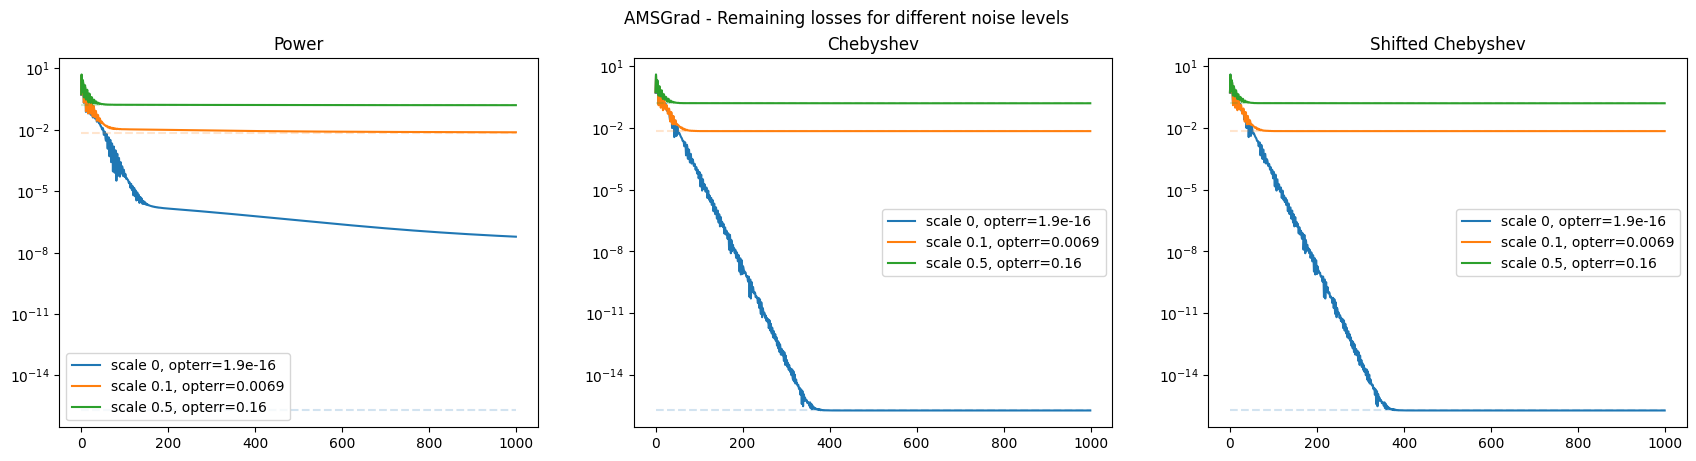

In [159]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.suptitle("AMSGrad - Remaining losses for different noise levels")
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

for i in range(len(splines)):
    col = next(colcycle)["color"]
    ysg = ysgauss[i]
    scale = ysgauss_scales[i]
    
    optcoeff = np.polyfit(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_POWER), ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_POWER)]
    optloss = l2_sq_loss(optcoeff, sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_POWER), ysg)
        
    ax1.semilogy(splines[i].total_loss_values, label="scale %g, opterr=%.2g" % (scale, optloss), c=col)
    ax1.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)  
 
    optcoeff = np.polyfit(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_CHEBYSHEV), ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_CHEBYSHEV)]
    optloss = l2_sq_loss(optcoeff, sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_CHEBYSHEV), ysg)
    
    ax2.semilogy(splines_chebyshev[i].total_loss_values, label="scale %g, opterr=%.2g" % (scale, optloss), c=col)
    ax2.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)  

    optcoeff = np.polyfit(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV), ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV)]
    optloss = l2_sq_loss(optcoeff, sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV), ysg)
   
    ax3.semilogy(splines_shifted_chebyshev[i].total_loss_values, label="scale %g, opterr=%.2g" % (scale, optloss), c=col)
    ax3.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)  

ax1.set_title("Power")
ax2.set_title("Chebyshev")
ax3.set_title("Shifted Chebyshev")

ax1.legend(loc="best")
ax2.legend(loc="best")
ax3.legend(loc="best")

### Interpretation
Generally it takes longer to get to the optimal approximation result for all bases with less noise.
Hovewer, while Chebyshev and Shifted Chebyshev bases are able to reach the optimum for all observed noise levels in under 500 epochs, 
Power Basis is only competitive with noise added to the input curve.


## Stability under noise for SGD

As seen earlier, SGD does only converge for Power Basis.

In [160]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': ck, 'continuity': False, 'degree': degree,
        'optimizer': 'SGD', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'power', 'shift_polynomial_centers': shift_polynomial_centers, 'learning_rate': learning_rate , 'mode': 'data_y',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results = pool.starmap(parallel.job, zip(ysgauss, repeat(kwargs)))

In [161]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': ck, 'continuity': False, 'degree': degree,
        'optimizer': 'SGD', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'chebyshev', 'shift_polynomial_centers': shift_polynomial_centers, 'learning_rate': learning_rate , 'mode': 'data_y',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_chebyshev = pool.starmap(parallel.job, zip(ysgauss, repeat(kwargs)))

In [162]:
kwargs = {'data_x': xs, 'data_y': ys, 'polynum': no_segments, 'ck': ck, 'continuity': False, 'degree': degree,
        'optimizer': 'SGD', 'n_epochs': epochs, 'gradient_regularization': False,
        'basis': 'shifted_chebyshev', 'shift_polynomial_centers': shift_polynomial_centers_sc, 'learning_rate': learning_rate , 'mode': 'data_y',
        'factor_approximation_quality': factor_approximation_quality, 'factor_ck_pressure': factor_ck_pressure}

pool = mp.Pool(mp.cpu_count())
results_shifted_chebyshev = pool.starmap(parallel.job, zip(ysgauss, repeat(kwargs)))

In [165]:
splines = [0.0] * len(results)
splines_chebyshev = [0.0] * len(results)
splines_shifted_chebyshev = [0.0] * len(results)

for i in range(len(results)):
    splines[i] = model.get_spline_from_coeffs(results[i][-1], xs, ysgauss[i], basis='power', shift_polynomial_centers=shift_polynomial_centers, ck=0, total_loss_values=results[i][1])
    splines_chebyshev[i] = model.get_spline_from_coeffs(results_chebyshev[i][-1], xs, ysgauss[i], basis='chebyshev', shift_polynomial_centers=shift_polynomial_centers, ck=0, total_loss_values=results_chebyshev[i][1])
    splines_shifted_chebyshev[i] = model.get_spline_from_coeffs(results_shifted_chebyshev[i][-1], xs, ysgauss[i], basis='shifted_chebyshev', shift_polynomial_centers=shift_polynomial_centers_sc, ck=0,  total_loss_values=results_shifted_chebyshev[i][1])

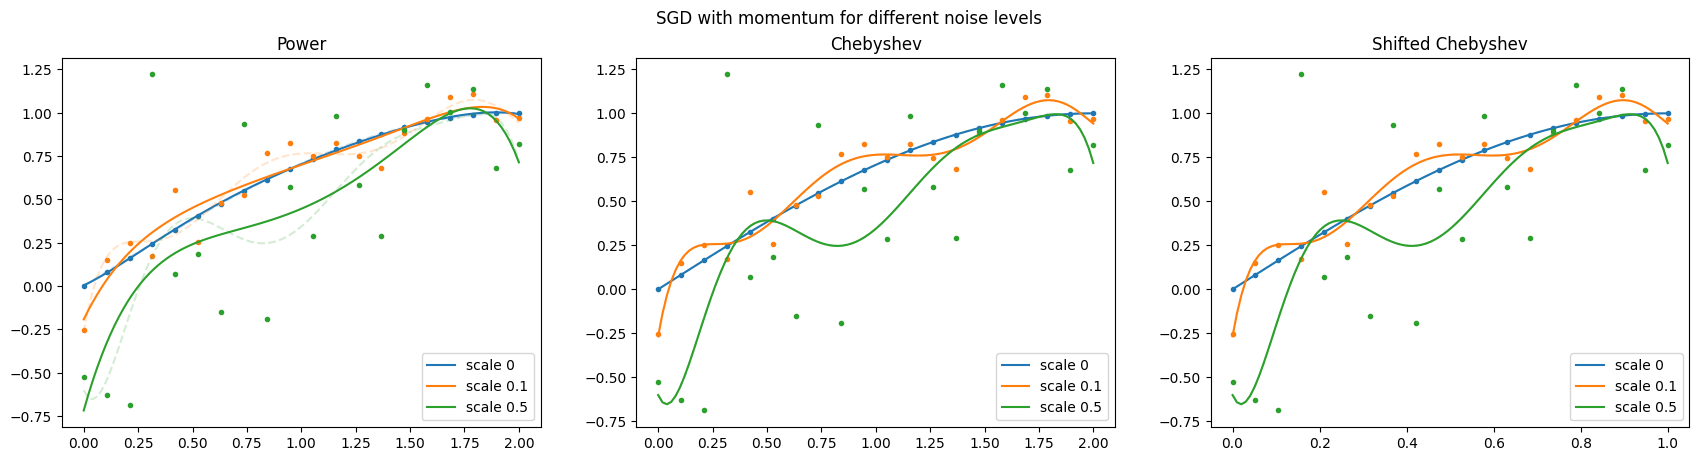

In [166]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.suptitle("SGD with momentum for different noise levels")
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

for i in range(len(splines)):
    col = next(colcycle)["color"]
    ps = splines[i].evaluate_spline_at_x(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_POWER))
    psc = splines_chebyshev[i].evaluate_spline_at_x(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_CHEBYSHEV))
    pssc = splines_shifted_chebyshev[i].evaluate_spline_at_x(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV))
    ysg = ysgauss[i]
    scale = ysgauss_scales[i]
    
    optcoeff = np.polyfit(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_POWER), ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_POWER)]
    optloss = l2_sq_loss(optcoeff, sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_POWER), ysg)
        
    ax1.plot(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_POWER), ysg, '.', c=col)
    ax1.plot(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_POWER), ps, label="scale %.2g" % scale, c=col)
    ax1.plot(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_POWER), psopt, c=col, linestyle="--", alpha=0.2) 
 
    optcoeff = np.polyfit(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_CHEBYSHEV), ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_CHEBYSHEV)]
    optloss = l2_sq_loss(optcoeff, sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_CHEBYSHEV), ysg)
    
    ax2.plot(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_CHEBYSHEV), ysg, '.', c=col)
    ax2.plot(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_CHEBYSHEV), psc, label="scale %.2g" % scale, c=col)
    ax2.plot(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_CHEBYSHEV), psopt, c=col, linestyle="--", alpha=0.2) 

    optcoeff = np.polyfit(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV), ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV)]
    optloss = l2_sq_loss(optcoeff, sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV), ysg)
   
    ax3.plot(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV), ysg, '.', c=col)
    ax3.plot(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV), pssc, label="scale %.2g" % scale, c=col)
    ax3.plot(sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV), psopt, c=col, linestyle="--", alpha=0.2) 
    
ax1.set_title("Power")
ax2.set_title("Chebyshev")
ax3.set_title("Shifted Chebyshev")

ax1.legend(loc="best")
ax2.legend(loc="best")
ax3.legend(loc="best")

Text(0.5, 1.0, 'Shifted Chebyshev')

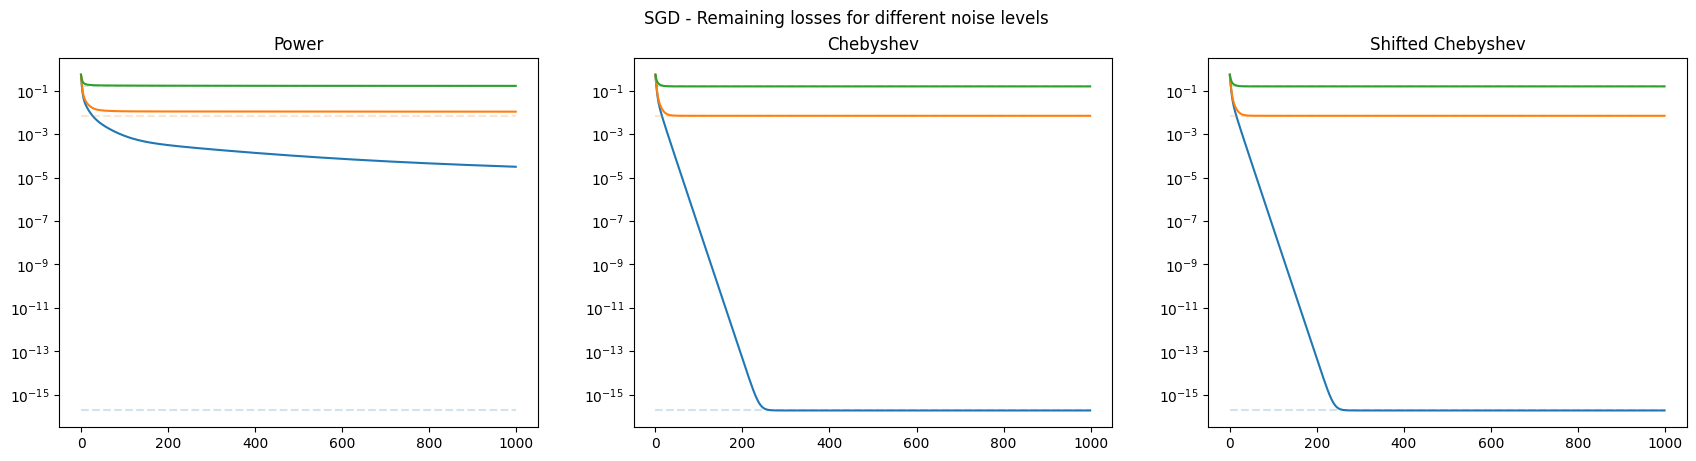

In [167]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_figwidth(21)
fig.suptitle("SGD - Remaining losses for different noise levels")
colcycle = iter(mpl.rcParams['axes.prop_cycle'])

for i in range(len(splines)):
    col = next(colcycle)["color"]
    ysg = ysgauss[i]
    scale = ysgauss_scales[i]
    
    optcoeff = np.polyfit(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_POWER), ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_POWER)]
    optloss = l2_sq_loss(optcoeff, sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_POWER), ysg)
        
    ax1.semilogy(splines[i].total_loss_values, label="scale %g, opterr=%.2g" % (scale, optloss), c=col)
    ax1.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)  
 
    optcoeff = np.polyfit(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_CHEBYSHEV), ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_CHEBYSHEV)]
    optloss = l2_sq_loss(optcoeff, sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_CHEBYSHEV), ysg)
    
    ax2.semilogy(splines_chebyshev[i].total_loss_values, label="scale %g, opterr=%.2g" % (scale, optloss), c=col)
    ax2.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)  

    optcoeff = np.polyfit(sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV), ysgauss[i], degree)[::-1]
    psopt = [evaluate(optcoeff, x) for x in sampledata.rescale_input_data(xss, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV)]
    optloss = l2_sq_loss(optcoeff, sampledata.rescale_input_data(xs, model.SEGMENT_SIZE_SHIFTED_CHEBYSHEV), ysg)
   
    ax3.semilogy(splines_shifted_chebyshev[i].total_loss_values, label="scale %g, opterr=%.2g" % (scale, optloss), c=col)
    ax3.hlines(optloss, xmin=0, xmax=epochs, linestyle="--", color=col, alpha=0.2)  

ax1.set_title("Power")
ax2.set_title("Chebyshev")
ax3.set_title("Shifted Chebyshev")

# ax1.legend(loc="best")
# ax2.legend(loc="best")
# ax3.legend(loc="best")

### Interpretation
Slower convergence for Power Basis, better convergence for Chebyshev basis.
**Interesting: Vanilla SGD is outperforming "modern" adaptive AMSGrad with Chebyshev basis.**